In [2]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

**1.- Cargar el Modelo Guardado:**

In [3]:
# Cargar el modelo
model = fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 2  # 1 clase (persona) + fondo
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Cargar los pesos guardados
model.load_state_dict(torch.load('fasterrcnn_person_detector.pth'))
model.eval()

# Mover el modelo a la GPU si está disponible
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/home/russell/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/russell/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_91897/3227987419.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. Th

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [4]:
print(device)

cuda


> Inferencia en imagenes

In [20]:
import cv2
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# def predict_and_draw_boxes(image_path, model, device, threshold=0.5):
#     # Leer la imagen
#     image = Image.open(image_path).convert("RGB")
    
#     # Transformar la imagen
#     image_tensor = F.to_tensor(image).unsqueeze(0).to(device)
    
#     # Realizar la predicción
#     with torch.no_grad():
#         predictions = model(image_tensor)
    
#     # Filtrar las detecciones por umbral de confianza
#     pred_boxes = predictions[0]['boxes'].cpu().numpy()
#     pred_scores = predictions[0]['scores'].cpu().numpy()
    
#     # Dibujar los cuadros delimitadores
#     draw = ImageDraw.Draw(image)
#     for i, box in enumerate(pred_boxes):
#         if pred_scores[i] >= threshold:
#             draw.rectangle(box.tolist(), outline="red", width=2)
    
#     # Mostrar la imagen con los cuadros delimitadores
#     plt.imshow(image)
#     plt.axis('off')
#     plt.show()
# Función para predecir y dibujar cuadros delimitadores en una imagen
def predict_and_draw_boxes(image_path, model, device, threshold=0.5):
    # Leer la imagen
    image = Image.open(image_path).convert("RGB")
    
    # Transformar la imagen
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)
    
    # Realizar la predicción
    with torch.no_grad():
        predictions = model(image_tensor)
    
    # Filtrar las detecciones por umbral de confianza
    pred_boxes = predictions[0]['boxes'].cpu().numpy()
    pred_scores = predictions[0]['scores'].cpu().numpy()
    pred_labels = predictions[0]['labels'].cpu().numpy()
    
    # Contar las personas detectadas
    num_people = sum(
        score >= threshold and label == 1
        for score, label in zip(pred_scores, pred_labels)
    )
    
    # Dibujar los cuadros delimitadores
    draw = ImageDraw.Draw(image)
    for i, box in enumerate(pred_boxes):
        if pred_scores[i] >= threshold and pred_labels[i] == 1:
            draw.rectangle(box.tolist(), outline="blue", width=2)
    
    # Añadir el número de personas detectadas
    draw.text((10, 10), f'People detected: {num_people}', fill="red")
    
    # Mostrar la imagen con los cuadros delimitadores
    plt.imshow(image)
    plt.axis('off')
    plt.show()


17125
Processing /home/russell/git/CountPeople/voc_dataset/VOCdevkit/VOC2012/JPEGImages/2008_006506.jpg


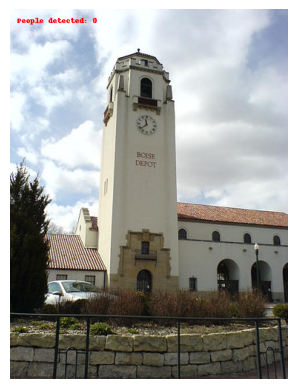

Processing /home/russell/git/CountPeople/voc_dataset/VOCdevkit/VOC2012/JPEGImages/2010_001665.jpg


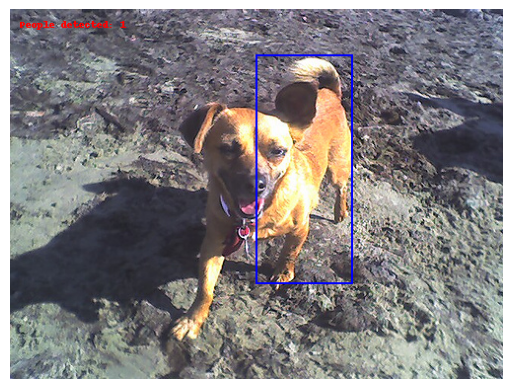

Processing /home/russell/git/CountPeople/voc_dataset/VOCdevkit/VOC2012/JPEGImages/2008_001729.jpg


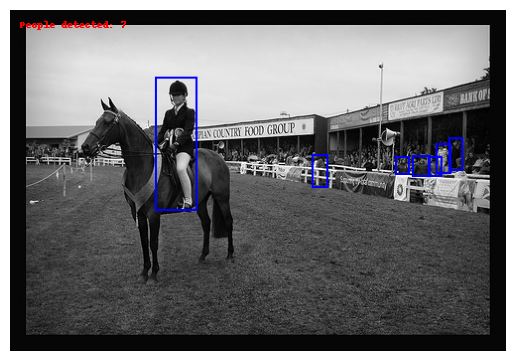

Processing /home/russell/git/CountPeople/voc_dataset/VOCdevkit/VOC2012/JPEGImages/2010_002496.jpg


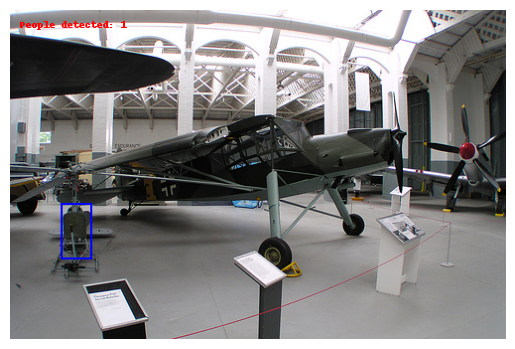

Processing /home/russell/git/CountPeople/voc_dataset/VOCdevkit/VOC2012/JPEGImages/2008_003592.jpg


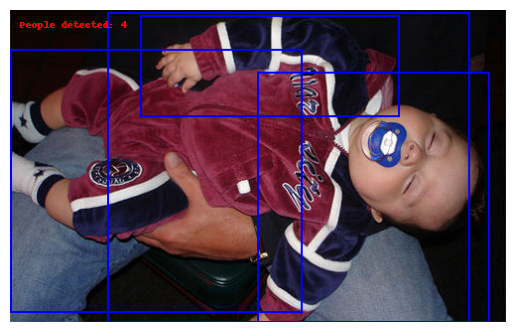

Processing /home/russell/git/CountPeople/voc_dataset/VOCdevkit/VOC2012/JPEGImages/2009_003933.jpg


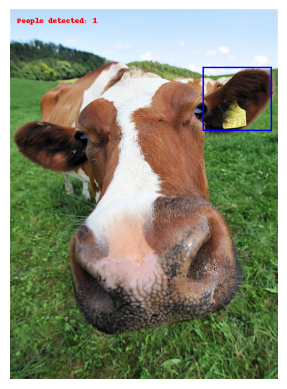

In [21]:
import os
root = '/home/russell/git/CountPeople/voc_dataset'
dir = os.path.join(root, 'VOCdevkit', 'VOC2012', 'JPEGImages')
# image_path = dir + '/2007_000068.jpg' 
# print(image_path)

# Realizar la predicción y dibujar los cuadros delimitadores
# predict_and_draw_boxes(image_path, model, device)


files = [f for f in os.listdir(dir) if f.endswith('.jpg') or f.endswith('.png')]
print(len(files))

# Procesar solo un número limitado de imágenes (por ejemplo, 6)
num_images_to_process = 6
for i, filename in enumerate(files):
    if i >= num_images_to_process:
        break
    
    image_path = os.path.join(dir, filename)
    print(f'Processing {image_path}')
    
    # Realizar la predicción y dibujar los cuadros delimitadores
    predict_and_draw_boxes(image_path, model, device)

In [15]:
import cv2

# def predict_and_draw_boxes_video(video_path, model, device, threshold=0.5):
#     # Abrir el video
#     cap = cv2.VideoCapture(video_path)
    
#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             break
        
#         # Convertir el frame a formato PIL
#         image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
#         # Transformar la imagen
#         image_tensor = F.to_tensor(image).unsqueeze(0).to(device)
        
#         # Realizar la predicción
#         with torch.no_grad():
#             predictions = model(image_tensor)
        
#         # Filtrar las detecciones por umbral de confianza
#         pred_boxes = predictions[0]['boxes'].cpu().numpy()
#         pred_scores = predictions[0]['scores'].cpu().numpy()
        
#         # Dibujar los cuadros delimitadores
#         for i, box in enumerate(pred_boxes):
#             if pred_scores[i] >= threshold:
#                 (x1, y1, x2, y2) = box.astype(int)
#                 cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        
#         # Mostrar el frame con los cuadros delimitadores
#         cv2.imshow('Person Detection', frame)
        
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
    
#     cap.release()
#     cv2.destroyAllWindows()


def predict_and_draw_boxes_video(video_path, model, device, threshold=0.5):
    # Abrir el video
    cap = cv2.VideoCapture(video_path)
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convertir el frame a formato PIL
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
        # Transformar la imagen
        image_tensor = F.to_tensor(image).unsqueeze(0).to(device)
        
        # Realizar la predicción
        with torch.no_grad():
            predictions = model(image_tensor)
        
        # Filtrar las detecciones por umbral de confianza
        pred_boxes = predictions[0]['boxes'].cpu().numpy()
        pred_scores = predictions[0]['scores'].cpu().numpy()
        pred_labels = predictions[0]['labels'].cpu().numpy()
        
        # Contar las personas detectadas
        num_people = sum(label == 1 for label in pred_labels if pred_scores[pred_labels == label] >= threshold)

        # Dibujar los cuadros delimitadores y el texto
        for i, box in enumerate(pred_boxes):
            if pred_scores[i] >= threshold:
                (x1, y1, x2, y2) = box.astype(int)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        
        # Añadir el texto con la cantidad de personas detectadas
        text = f'People Detected: {num_people}'
        cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
        
        # Mostrar el frame con los cuadros delimitadores y el texto
        cv2.imshow('Person Detection', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()


In [25]:
video_path = 0

predict_and_draw_boxes_video(video_path, model, device)


[ WARN:0@519.156] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@519.157] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
